In [ ]:
!pip install torch torchvision transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import time
from tqdm import tqdm

In [ ]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
# Unzip function
import zipfile

def extract_zip(file_path):
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('/content/')
        print(f"Extraction successful: {file_path}")
    except zipfile.BadZipFile:
        print(f"Error extracting {file_path}. Please check the file.")

# Extract the files
extract_zip('/content/train.zip')
extract_zip('/content/test.zip')

Extraction successful: /content/train.zip
Extraction successful: /content/test.zip


In [ ]:
# Bildtransformationen
transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Datensätze laden
train_dataset = datasets.ImageFolder("/content/train", transform=transform)
test_dataset = datasets.ImageFolder("/content/test", transform=transform)

# DataLoader für Training und Test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Train dataset size: {len(test_dataset)}")


Train dataset size: 31761
Train dataset size: 7955


In [ ]:
# Class count display function
def display_class_distribution(dataset, dataset_name="Dataset"):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1

    print(f"Loaded {len(dataset)} images from {dataset_name}")
    for class_name, count in class_counts.items():
        percentage = (count / len(dataset)) * 100
        print(f"Class {class_name}: {count} images ({percentage:.1f}%)")

# Display class distribution for train and validation sets
display_class_distribution(train_dataset, "train")
display_class_distribution(test_dataset, "test")

Loaded 31761 images from train
Class angry: 3995 images (12.6%)
Class disgusted: 3488 images (11.0%)
Class fearful: 4097 images (12.9%)
Class happy: 7215 images (22.7%)
Class neutral: 4965 images (15.6%)
Class sad: 4830 images (15.2%)
Class surprised: 3171 images (10.0%)
Loaded 7955 images from test
Class angry: 958 images (12.0%)
Class disgusted: 888 images (11.2%)
Class fearful: 1024 images (12.9%)
Class happy: 1774 images (22.3%)
Class neutral: 1233 images (15.5%)
Class sad: 1247 images (15.7%)
Class surprised: 831 images (10.4%)


In [ ]:
# Set up model, optimizer, and criterion
num_classes = len(train_dataset.classes)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize learning rate scheduler and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

In [ ]:
# Metric storage
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
learning_rate_history = []
precision_history, recall_history, f1_score_history = [], [], []

In [ ]:
# Trainingsschleife
epochs = 5  # Passe die Anzahl der Epochen an
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    learning_rate_history.append(current_lr)

    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch + 1}/{epochs}]", unit="batch") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.update(1)
            pbar.set_postfix({"Loss": loss.item(), "Accuracy": 100 * correct / total})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    # Epoch-Ende Ausgaben
    epoch_duration = time.time() - start_time
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # Scheduler anpassen
    scheduler.step(epoch_train_loss)

    # Early Stopping
    if epoch_train_loss < best_val_loss:
        best_val_loss = epoch_train_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/colab_results/best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Testphase
model.eval()
test_correct, test_total = 0, 0
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Berechnung der Testgenauigkeit und anderer Metriken
test_accuracy = 100 * test_correct / test_total
test_precision = precision_score(all_labels, all_predictions, average='macro')
test_recall = recall_score(all_labels, all_predictions, average='macro')
test_f1_score = f1_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}")

# Speichern der Trainingshistorie
training_history = {
    'train_loss': train_loss_history,
    'train_accuracy': train_accuracy_history,
    'learning_rate': learning_rate_history,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1_score': test_f1_score
}

torch.save(training_history, '/content/drive/MyDrive/colab_results/training_history.pth')
print("Training history saved as 'training_history.pth' in Google Drive")


Epoch [1/5]: 100%|██████████| 497/497 [19:25<00:00,  2.34s/batch, Loss=0.761, Accuracy=55.7]


Epoch [1/5], Train Loss: 1.1698, Train Accuracy: 55.69%, Duration: 1165.10 seconds


Epoch [2/5]: 100%|██████████| 497/497 [19:20<00:00,  2.34s/batch, Loss=1.07, Accuracy=58.6]


Epoch [2/5], Train Loss: 1.0988, Train Accuracy: 58.59%, Duration: 1160.73 seconds


Epoch [3/5]: 100%|██████████| 497/497 [19:20<00:00,  2.33s/batch, Loss=0.826, Accuracy=60.8]


Epoch [3/5], Train Loss: 1.0482, Train Accuracy: 60.77%, Duration: 1160.46 seconds


Epoch [4/5]: 100%|██████████| 497/497 [19:19<00:00,  2.33s/batch, Loss=0.888, Accuracy=61.5]


Epoch [4/5], Train Loss: 1.0193, Train Accuracy: 61.49%, Duration: 1159.85 seconds


Epoch [5/5]: 100%|██████████| 497/497 [19:20<00:00,  2.34s/batch, Loss=0.847, Accuracy=62.5]


Epoch [5/5], Train Loss: 0.9929, Train Accuracy: 62.52%, Duration: 1160.95 seconds
Test Accuracy: 61.11%
Test Precision: 0.6115
Test Recall: 0.5963
Test F1-Score: 0.5985
Training history saved as 'training_history.pth' in Google Drive


In [ ]:
# Modell und Optimizer laden
num_classes = len(train_dataset.classes)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_results/best_model.pth'))  # Lade die gespeicherten Gewichtungen
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Setze den Optimizer wie zuvor
criterion = nn.CrossEntropyLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-843e54b0742a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Thi

In [ ]:
# Trainiere das Modell für weitere 5 Epochen
additional_epochs = 5
total_epochs = epochs + additional_epochs  # Gesamtanzahl der Epochen erhöhen

for epoch in range(epochs, total_epochs):  # Startet von der bisherigen Anzahl der Epochen
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    learning_rate_history.append(current_lr)

    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch + 1}/{total_epochs}]", unit="batch") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.update(1)
            pbar.set_postfix({"Loss": loss.item(), "Accuracy": 100 * correct / total})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    epoch_duration = time.time() - start_time
    print(f"Epoch [{epoch + 1}/{total_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    scheduler.step(epoch_train_loss)

    # Early Stopping
    if epoch_train_loss < best_val_loss:
        best_val_loss = epoch_train_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/colab_results/best_model10.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Abschliessende Testphase und Speicherung der Trainingshistorie
model.eval()
test_correct, test_total = 0, 0
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_precision = precision_score(all_labels, all_predictions, average='macro')
test_recall = recall_score(all_labels, all_predictions, average='macro')
test_f1_score = f1_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy after additional training: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}")

# Aktualisierte Trainingshistorie speichern
training_history = {
    'train_loss': train_loss_history,
    'train_accuracy': train_accuracy_history,
    'learning_rate': learning_rate_history,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1_score': test_f1_score
}

torch.save(training_history, '/content/drive/MyDrive/colab_results/training_history.pth')
print("Updated training history saved as 'training_history5.pth' in Google Drive")

Epoch [6/10]: 100%|██████████| 497/497 [19:22<00:00,  2.34s/batch, Loss=1.03, Accuracy=63.9]


Epoch [6/10], Train Loss: 0.9691, Train Accuracy: 63.89%, Duration: 1162.42 seconds


Epoch [7/10]: 100%|██████████| 497/497 [19:21<00:00,  2.34s/batch, Loss=1.15, Accuracy=64.5]


Epoch [7/10], Train Loss: 0.9434, Train Accuracy: 64.54%, Duration: 1161.14 seconds


Epoch [8/10]:  84%|████████▎ | 415/497 [16:11<03:13,  2.36s/batch, Loss=0.977, Accuracy=64.9]

In [ ]:
# Bildtransformationen, um die Bilder an das ViT-Modell anzupassen
transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


# Laden des Datensatzes
train_dataset = datasets.ImageFolder("/content/train", transform=transform)
test_dataset = datasets.ImageFolder("/content/test", transform=transform)

# DataLoader für Training und Test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 31761
Test dataset size: 7955


In [ ]:
# Anzahl der Klassen in deinem Datensatz
num_classes = len(train_dataset.classes)

# Lade das vortrainierte ViT-Modell und ignoriere Grössenunterschiede
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # Grössenunterschiede ignorieren
)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Definiere den Optimizer und die Loss-Funktion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Anzeige der Anzahl der Bilder pro Klasse im Trainings- und Testdatensatz
def display_class_distribution(dataset, dataset_name="Dataset"):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1

    print(f"Loaded {len(dataset)} images from {dataset_name}")
    for class_name, count in class_counts.items():
        percentage = (count / len(dataset)) * 100
        print(f"Class {class_name}: {count} images ({percentage:.1f}%)")

# Anzeige für den Trainings- und Testdatensatz
display_class_distribution(train_dataset, "train")
display_class_distribution(test_dataset, "test")

Loaded 31761 images from train
Class angry: 3995 images (12.6%)
Class disgusted: 3488 images (11.0%)
Class fearful: 4097 images (12.9%)
Class happy: 7215 images (22.7%)
Class neutral: 4965 images (15.6%)
Class sad: 4830 images (15.2%)
Class surprised: 3171 images (10.0%)
Loaded 7955 images from test
Class angry: 958 images (12.0%)
Class disgusted: 888 images (11.2%)
Class fearful: 1024 images (12.9%)
Class happy: 1774 images (22.3%)
Class neutral: 1233 images (15.5%)
Class sad: 1247 images (15.7%)
Class surprised: 831 images (10.4%)


In [ ]:
import time

# Anzahl der Epochen
epochs = 5

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Vorwärtsdurchlauf
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Berechnung der Genauigkeit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Durchschnittlicher Verlust und Genauigkeit
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")


Epoch [1/5], Loss: 1.3546, Accuracy: 48.81%, Duration: 1171.73 seconds
Epoch [2/5], Loss: 1.1344, Accuracy: 57.23%, Duration: 1176.35 seconds
Epoch [3/5], Loss: 1.0679, Accuracy: 60.17%, Duration: 1174.93 seconds
Epoch [4/5], Loss: 1.0219, Accuracy: 61.75%, Duration: 1173.65 seconds
Epoch [5/5], Loss: 0.9954, Accuracy: 63.04%, Duration: 1173.42 seconds


In [ ]:
import time

# Anzahl der Epochen
epochs = 5

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Vorwärtsdurchlauf
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Berechnung der Genauigkeit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Durchschnittlicher Verlust und Genauigkeit
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")


In [ ]:
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# Definiere den Optimizer nur für die trainierbaren Parameter
optimizer = torch.optim.AdamW([
    {"params": model.vit.encoder.layer[-1].parameters(), "lr": 5e-6},  # Langsames Lernen für den letzten Layer
    {"params": model.classifier.parameters(), "lr": 1e-4}  # Höhere Lernrate für den Klassifikations-Head
])

# Scheduler für die Lernraten-Anpassung
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Mixed Precision Training: GradScaler
scaler = GradScaler()

# Anzahl der Epochen
epochs = 30

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Mixed Precision Training mit autocast
        with autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        # Rückwärtsdurchlauf und Optimierung mit Mixed Precision
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Berechnung der Genauigkeit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Durchschnittlicher Verlust und Genauigkeit
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # Scheduler nach jeder Epoche anpassen
    scheduler.step()


<ipython-input-62-610866396df0>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-62-610866396df0>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/30], Loss: 0.9107, Accuracy: 67.00%, Duration: 12.39 seconds
Epoch [2/30], Loss: 0.9270, Accuracy: 66.43%, Duration: 10.97 seconds
Epoch [3/30], Loss: 0.9025, Accuracy: 67.57%, Duration: 12.02 seconds
Epoch [4/30], Loss: 0.8899, Accuracy: 68.29%, Duration: 11.16 seconds
Epoch [5/30], Loss: 0.9490, Accuracy: 66.36%, Duration: 10.65 seconds
Epoch [6/30], Loss: 0.9346, Accuracy: 66.21%, Duration: 12.11 seconds
Epoch [7/30], Loss: 0.9362, Accuracy: 66.43%, Duration: 11.05 seconds
Epoch [8/30], Loss: 0.9530, Accuracy: 66.29%, Duration: 11.77 seconds
Epoch [9/30], Loss: 0.9520, Accuracy: 65.29%, Duration: 11.45 seconds
Epoch [10/30], Loss: 0.8779, Accuracy: 67.50%, Duration: 11.29 seconds
Epoch [11/30], Loss: 0.9006, Accuracy: 68.29%, Duration: 10.72 seconds
Epoch [12/30], Loss: 0.8973, Accuracy: 67.50%, Duration: 12.08 seconds
Epoch [13/30], Loss: 0.8926, Accuracy: 67.43%, Duration: 9.72 seconds
Epoch [14/30], Loss: 0.9722, Accuracy: 64.57%, Duration: 12.89 seconds
Epoch [15/30], L

In [ ]:
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# Definiere den Optimizer nur für die trainierbaren Parameter
optimizer = torch.optim.AdamW([
    {"params": model.vit.encoder.layer[-1].parameters(), "lr": 5e-6},  # Langsames Lernen für den letzten Layer
    {"params": model.classifier.parameters(), "lr": 1e-4}  # Höhere Lernrate für den Klassifikations-Head
])

# Scheduler für die Lernraten-Anpassung
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Mixed Precision Training: GradScaler
scaler = GradScaler()

# Anzahl der Epochen
epochs = 50

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Mixed Precision Training mit autocast
        with autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        # Rückwärtsdurchlauf und Optimierung mit Mixed Precision
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Berechnung der Genauigkeit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Durchschnittlicher Verlust und Genauigkeit
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # Scheduler nach jeder Epoche anpassen
    scheduler.step()


<ipython-input-67-75bacf3e1a2c>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-67-75bacf3e1a2c>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Loss: 0.8808, Accuracy: 67.57%, Duration: 13.57 seconds
Epoch [2/50], Loss: 0.8758, Accuracy: 68.43%, Duration: 11.28 seconds
Epoch [3/50], Loss: 0.8982, Accuracy: 66.86%, Duration: 10.90 seconds
Epoch [4/50], Loss: 0.8975, Accuracy: 67.36%, Duration: 11.75 seconds
Epoch [5/50], Loss: 0.9419, Accuracy: 66.07%, Duration: 9.94 seconds
Epoch [6/50], Loss: 0.8989, Accuracy: 67.64%, Duration: 13.67 seconds
Epoch [7/50], Loss: 0.8675, Accuracy: 69.14%, Duration: 10.18 seconds
Epoch [8/50], Loss: 0.8902, Accuracy: 68.21%, Duration: 12.25 seconds
Epoch [9/50], Loss: 0.9304, Accuracy: 67.14%, Duration: 12.44 seconds
Epoch [10/50], Loss: 0.8849, Accuracy: 68.50%, Duration: 12.09 seconds
Epoch [11/50], Loss: 0.8952, Accuracy: 67.07%, Duration: 10.70 seconds
Epoch [12/50], Loss: 0.8959, Accuracy: 67.57%, Duration: 11.49 seconds
Epoch [13/50], Loss: 0.8839, Accuracy: 68.43%, Duration: 11.92 seconds
Epoch [14/50], Loss: 0.8435, Accuracy: 69.57%, Duration: 9.86 seconds
Epoch [15/50], Lo

In [ ]:
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast  # Aktualisierte Import-Befehle

# Definiere den Optimizer nur für die trainierbaren Parameter
optimizer = torch.optim.AdamW([
    {"params": model.vit.encoder.layer[-1].parameters(), "lr": 5e-5},  # Höhere Lernrate für den letzten Layer
    {"params": model.classifier.parameters(), "lr": 5e-4}  # Höhere Lernrate für den Klassifikations-Head
])

# Scheduler für die Lernraten-Anpassung basierend auf Validierungsverlust
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Mixed Precision Training: GradScaler
scaler = GradScaler('cuda')  # Aktualisierung für FutureWarning

# Anzahl der Epochen
epochs = 50

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Mixed Precision Training mit autocast
        with autocast('cuda'):  # Aktualisierung für FutureWarning
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        # Rückwärtsdurchlauf und Optimierung mit Mixed Precision
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Berechnung der Genauigkeit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Durchschnittlicher Trainingsverlust und Genauigkeit
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_duration = time.time() - start_time

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # Evaluation auf dem Validierungsdatensatz
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Durchschnittlicher Validierungsverlust und Genauigkeit
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Scheduler basierend auf Validierungsverlust anpassen
    scheduler.step(val_loss)


Epoch [1/50], Loss: 1.5988, Accuracy: 37.86%, Duration: 20.18 seconds
Validation Loss: 1.6093, Validation Accuracy: 38.21%
Epoch [2/50], Loss: 1.5522, Accuracy: 39.79%, Duration: 19.64 seconds
Validation Loss: 1.5230, Validation Accuracy: 41.79%
Epoch [3/50], Loss: 1.5088, Accuracy: 41.93%, Duration: 19.50 seconds
Validation Loss: 1.5107, Validation Accuracy: 43.93%
Epoch [4/50], Loss: 1.4792, Accuracy: 43.43%, Duration: 19.98 seconds
Validation Loss: 1.5031, Validation Accuracy: 46.43%
Epoch [5/50], Loss: 1.4118, Accuracy: 48.29%, Duration: 18.88 seconds
Validation Loss: 1.5835, Validation Accuracy: 38.57%
Epoch [6/50], Loss: 1.4119, Accuracy: 46.93%, Duration: 18.75 seconds
Validation Loss: 1.5221, Validation Accuracy: 38.93%
Epoch [7/50], Loss: 1.3724, Accuracy: 47.14%, Duration: 19.35 seconds
Validation Loss: 1.4905, Validation Accuracy: 45.00%
Epoch [8/50], Loss: 1.3138, Accuracy: 49.93%, Duration: 19.49 seconds
Validation Loss: 1.4578, Validation Accuracy: 46.79%
Epoch [9/50], Lo

<Figure size 1000x1000 with 0 Axes>

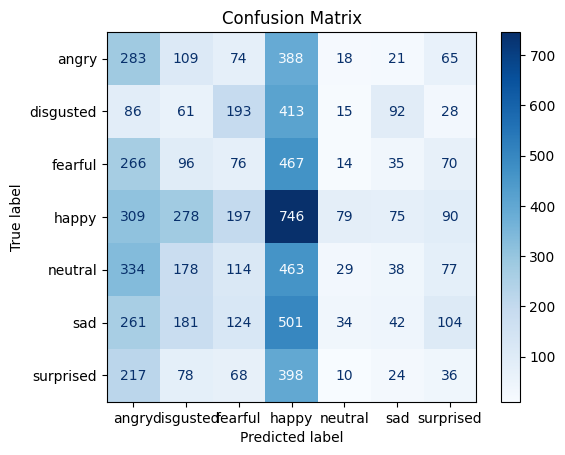

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Alle Vorhersagen und Labels sammeln
all_labels = []
all_preds = []

model.eval()  # Setzt das Modell in den Evaluierungsmodus

with torch.no_grad():  # Deaktiviert das Gradienten-Tracking
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Modellvorhersagen sammeln
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Confusion-Matrix berechnen
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

# Confusion-Matrix anzeigen
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


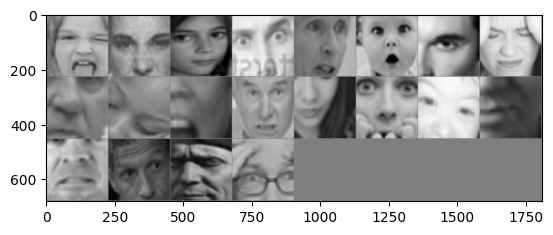

GroundTruth: disgusted disgusted neutral surprised angry surprised neutral fearful sad sad fearful angry sad fearful happy surprised disgusted fearful angry fearful
Predicted:  disgusted angry sad surprised disgusted surprised surprised fearful disgusted sad angry angry neutral surprised happy angry angry fearful disgusted fearful


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img):
    img = img / 2 + 0.5  # Denormalisieren
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Testdatensatz mit shuffle=True für Zufälligkeit
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=True,  # Aktiviert zufällige Auswahl
    num_workers=10,
    pin_memory=True
)

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images).logits
_, predicted = torch.max(outputs, 1)

# Zeige die Bilder und Vorhersage
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth:', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(20)))
print('Predicted: ', ' '.join(f'{train_dataset.classes[predicted[j]]}' for j in range(20)))

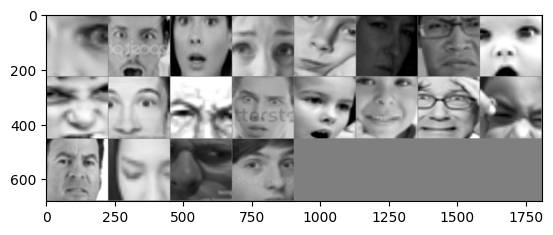

GroundTruth: surprised surprised fearful fearful neutral angry disgusted surprised
Predicted:  surprised surprised surprised fearful sad disgusted disgusted surprised


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Ein paar Beispielbilder mit ihren Vorhersagen anzeigen
def imshow(img):
    img = img / 2 + 0.5  # Denormalisieren
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Einige Bilder vom Testdatensatz anzeigen und vorhersagen
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Verwende next() anstelle von .next()
images, labels = images.to(device), labels.to(device)

outputs = model(images).logits
_, predicted = torch.max(outputs, 1)

# Zeige die Bilder und Vorhersage.
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth:', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(8)))
print('Predicted: ', ' '.join(f'{train_dataset.classes[predicted[j]]}' for j in range(8)))



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from google.colab import drive

# Google Drive mounten
drive.mount('/content/drive')

# Erstellen des Ordners "colab" falls er nicht existiert
colab_folder_path = "/content/drive/MyDrive/ds2"
if not os.path.exists(colab_folder_path):
    os.makedirs(colab_folder_path)

# Speichern des Modells
model_path = os.path.join(colab_folder_path, "vit_model3.pth")
torch.save(model.state_dict(), model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), 'visualTransformer3.pth')

In [ ]:
#für am schluss

# Nur die letzten Layer und den Head des Modells trainieren
for param in model.parameters():
    param.requires_grad = False

# Entfrieren der letzten Transformer-Block-Parameter und des Klassifikations-Heads
for param in model.vit.encoder.layer[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Differenzierte Lernrate für fein abgestimmte Layer
optimizer = torch.optim.AdamW([
    {"params": model.vit.encoder.layer[-1].parameters(), "lr": 5e-5},  # Langsames Lernen für den letzten Layer
    {"params": model.classifier.parameters(), "lr": 5e-4}  # Höhere Lernrate für den Klassifizierungs-Head
])
